In [1]:
import numpy as np
import pandas as pd
import pickle
from pathlib import Path
from collections import OrderedDict
from tqdm.notebook import trange

import matplotlib.pyplot as plt
import matplotlib as mpl

from function.utilities import get_subset

# param

In [2]:
#####CHANGE HERE#####
aa_order = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']
algorithm = 'VLXT'
sample_nums_for_rbp = 1533
sample_nums_for_mrbp = 688
sample_times = 100
#####CHANGE HERE#####

# read data

In [3]:
pondr_disorder_identification_path = Path("./output/pondr_disorder_identification")
od_human_df = pd.read_pickle(pondr_disorder_identification_path/'{}_od_human_df.pkl'.format(algorithm))
od_rbp_df = get_subset(od_human_df,'rbp')
od_mrbp_df = get_subset(od_human_df,'mrbp')

# relative ratio stat

In [4]:
#content
def aa_content(df):
    order_sequence_all = ''
    disorder_sequence_all = ''
    aa_order_od = aa_order + ['*']
    
    for index, row in df.iterrows():
        
        uniprot_id = row['uniprot_id']
        order_sequence = row['order_sequence']
        disorder_sequence = row['disorder_sequence']
        
        order_sequence_all = order_sequence_all + order_sequence
        disorder_sequence_all = disorder_sequence_all + disorder_sequence
        
    order_sequence_dict = OrderedDict({i : order_sequence_all.count(i) for i in aa_order_od})
    order_sequence_dict['total'] = sum(order_sequence_dict.values())
        
    disorder_sequence_dict = OrderedDict({i : disorder_sequence_all.count(i) for i in aa_order_od})
    disorder_sequence_dict['total'] = sum(disorder_sequence_dict.values())
        
    return {"order":order_sequence_dict,
            "disorder":disorder_sequence_dict}

#disorder rtatio
def subset_human_ratio(subset,human):
    
    subset_percent = [subset['disorder'][x]/(subset['order'][x]+subset['disorder'][x]) for x in aa_order]
    human_percent = [human['disorder'][x]/(human['order'][x]+human['disorder'][x]) for x in aa_order]
    
    ratio = [np.log(i / j) for i, j in zip(subset_percent, human_percent)]
    
    return {"aa_order":aa_order,
            "ratio":ratio}

def population(od_subset_df,human_df):
    ratio_matrix = np.zeros((1,20))
    human_content = aa_content(human_df)
    subset_content = aa_content(od_subset_df)
    
    subset_human_ratio_dict = subset_human_ratio(subset_content,human_content)
    ratio = subset_human_ratio_dict['ratio']
    aa_order = subset_human_ratio_dict['aa_order']
    
    ratio_matrix[0][:] = ratio
    
    return {"aa_order":aa_order,
            "ratio_matrix":ratio_matrix}

def sample(od_human_df,sample_nums=1542,sample_times=50):
    
    ratio_matrix = np.zeros((sample_times,20))
    human_content = aa_content(od_human_df)
    
    t = trange(sample_times, leave=True)
    for i in t:
        
        sampled_df = od_human_df.sample(sample_nums)
        human_sampled_content = aa_content(sampled_df)
        
        subset_human_ratio_dict = subset_human_ratio(human_sampled_content,human_content)
        ratio = subset_human_ratio_dict['ratio']
        aa_order = subset_human_ratio_dict['aa_order']
        
        ratio_matrix[i][:] = ratio
    
    return {"aa_order":aa_order,
            "ratio_matrix":ratio_matrix}

In [ ]:
rbp_population_dict = population(od_rbp_df,od_human_df)
human_sample_for_rbp = sample(od_human_df,sample_nums=sample_nums_for_rbp,sample_times=sample_times)

mrbp_population_dict = population(od_mrbp_df,od_human_df)
human_sample_for_mrbp = sample(od_human_df,sample_nums=sample_nums_for_mrbp,sample_times=sample_times)

  0%|          | 0/100 [00:00<?, ?it/s]

# output

In [7]:
output = {"aa_order":rbp_population_dict['aa_order'],
          "rbp":{"population":rbp_population_dict['ratio_matrix'],
                 "human_sample":human_sample_for_rbp['ratio_matrix']},
          "mrbp":{"population":mrbp_population_dict['ratio_matrix'],
                 "human_sample":human_sample_for_mrbp['ratio_matrix']},
          }

In [8]:
output

{'aa_order': ['A',
  'C',
  'D',
  'E',
  'F',
  'G',
  'H',
  'I',
  'K',
  'L',
  'M',
  'N',
  'P',
  'Q',
  'R',
  'S',
  'T',
  'V',
  'W',
  'Y'],
 'rbp': {'population': array([[0.10991989, 0.11366867, 0.14207587, 0.07783639, 0.26022519,
          0.13805177, 0.1414975 , 0.16970016, 0.18352832, 0.10342976,
          0.1384307 , 0.16861303, 0.05996346, 0.07441747, 0.16290118,
          0.14912609, 0.10580395, 0.13200767, 0.29251642, 0.31407642]]),
  'human_sample': array([[ 0.01004531, -0.00676747,  0.0077072 , ...,  0.02637661,
           0.01574112, -0.00247178],
         [ 0.01134552,  0.01773674, -0.00481687, ..., -0.00118563,
           0.04090159, -0.01824337],
         [ 0.01697346, -0.01069323,  0.00822874, ...,  0.02514361,
           0.02024846,  0.00854072],
         ...,
         [ 0.02112025, -0.00544842,  0.00928444, ...,  0.02030991,
           0.00720036,  0.00601782],
         [ 0.01425441,  0.05840779,  0.01617762, ...,  0.03431467,
           0.00106469, -0.0017

# plot

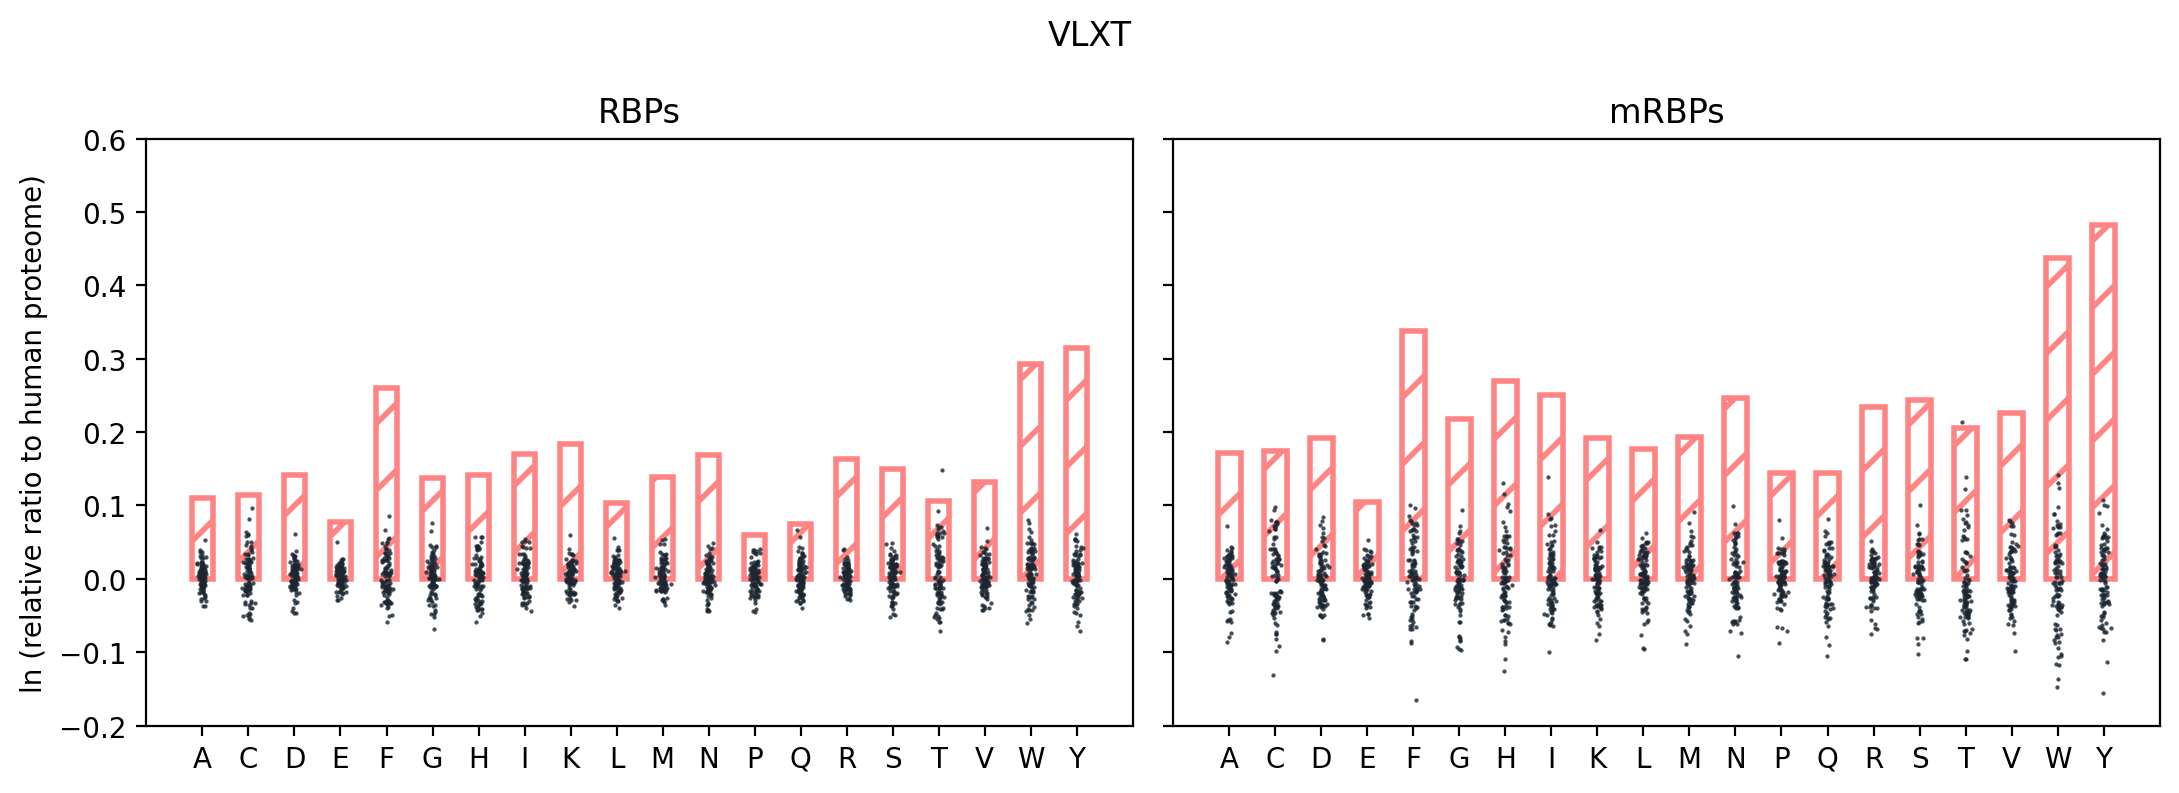

In [12]:
mpl.rcParams['hatch.linewidth'] = 2
f, (a0,a1) = plt.subplots(1,2,sharex=True,sharey=True,figsize=(11,4),dpi=200)

X = np.arange(len(aa_order))

noise=np.random.normal(0, 0.05, (output['rbp']['human_sample'].shape))
for index,i in enumerate(output['rbp']['human_sample']):
    a0.scatter(X+noise[index],i,color=(0.105,0.149,0.192,0.8),s=0.3,zorder=10)
a0.bar(X,output['rbp']['population'][0],width=0.45,tick_label=aa_order,zorder=0,color='white',hatch='/',linewidth=2,edgecolor='#ff8484')
a0.set_title("RBPs")
a0.set_ylabel("ln (relative ratio to human proteome)")
a0.set_ylim(-0.2,0.6)

noise=np.random.normal(0, 0.05, (output['mrbp']['human_sample'].shape))
for index,i in enumerate(output['mrbp']['human_sample']):
    a1.scatter(X+noise[index],i,color=(0.105,0.149,0.192,0.8),s=0.3,zorder=10)
a1.bar(X,output['mrbp']['population'][0],width=0.5,tick_label=aa_order,zorder=0,color='white',hatch='/',linewidth=2,edgecolor='#ff8484')
a1.set_title("mRBPs")



f.suptitle(algorithm)
f.tight_layout()